In [1]:
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression

#### Example: Credit card default prediction

- We want to predict whether a customers will default on their credit card debt based on income, monthly balance, and studentness.

- We model a customer defaulting using the **logistic regression model**:
  $$
  y\sim \operatorname{Bernoulli}\big(\texttt{default}\mid p\big),
  $$
  where
  $$
  \log\left(\frac p{1-p}\right) = a + b\,\texttt{income}+c\,\texttt{balance} + d\,\texttt{student}
  $$


#### Interpreting the coefficient of a binary feature in a logistic regression model

- Odds of defaulting:&nbsp;
  $\displaystyle{{o} = \frac{p}{1-p}}$
- From the logistic regression model:

  $$
  \begin{aligned}
  \log\frac{o_{\text{student}}}
  {o_{\text{nonstudent}}} &=
  \log\left(\frac{p_{\text{student}}}{1-p_{\text{student}}}\right) - \log\left(\frac{p_{\text{nonstudent}}}{1-p_{\text{nonstudent}}}\right)\\
  &= \phantom{-}(a + b\,\texttt{income}+c\,\texttt{balance} + d\,(1))\\&\phantom{=}-(a + b\,\texttt{income}+c\,\texttt{balance} + d\,(0))\\
  &= d\\
  \frac{o_{\text{student}}}{o_{\text{nonstudent}}} &= e^{d}\approx 0.54
  \end{aligned}
  $$

- **_The odds of a student defaulting are roughly half those of a nonstudent with comparable income and balance._**


In [2]:
df = pd.read_csv("../data/Default.csv")
df

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879
...,...,...,...,...
9995,0,0,711.555020,52992.378914
9996,0,0,757.962918,19660.721768
9997,0,0,845.411989,58636.156984
9998,0,0,1569.009053,36669.112365


In [3]:
X = df[["income", "balance", "student"]]
y = df["default"]
model = LogisticRegression()
model.fit(X, y)

a = model.intercept_
b, c, d = model.coef_.squeeze()

assert np.exp(d).round(2) == 0.54  # See "interpretation" markdown cell.

In [4]:
p = model.predict_proba(X)[:, 1]
all(model.predict(X) == (p >= 0.5))

True

In [5]:
x = pd.DataFrame(
    {
        "income": [10000, 10000],
        "balance": [2000, 2000],
        "student": [1, 0],
    }
)

model.predict(x), model.predict_proba(x)[:, 1]

(array([0, 1]), array([0.49661381, 0.64543196]))

In [6]:
p_student = model.predict_proba(x)[0, 1]
p_nonstudent = model.predict_proba(x)[1, 1]

o_student = p_student / (1 - p_student)
o_nonstudent = p_nonstudent / (1 - p_nonstudent)

assert np.isclose(
    np.log(o_student / o_nonstudent), d
)  # See "interpretation" markdown cell.

- Let's compare risk of default for student versus nonstudent cardholders with incomes of $10000 for a range of balances.

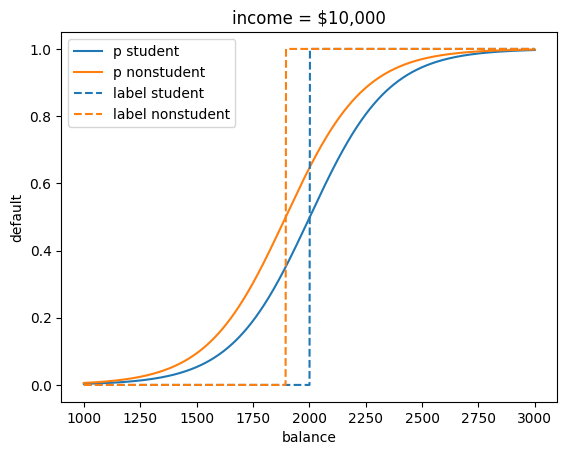

In [7]:
balance = np.linspace(1000, 3000, 1000)

x_student = pd.DataFrame(
    {
        "income": [10000 for _ in balance],
        "balance": balance,
        "student": [1 for _ in balance],
    }
)

x_nonstudent = pd.DataFrame(
    {
        "income": [10000 for _ in balance],
        "balance": balance,
        "student": [0 for _ in balance],
    }
)

p_student = model.predict_proba(x_student)[:, 1]
p_nonstudent = model.predict_proba(x_nonstudent)[:, 1]

pred_student = model.predict(x_student)
pred_nonstudent = model.predict(x_nonstudent)

plt.plot(balance, p_student, label="p student")
plt.plot(balance, p_nonstudent, label="p nonstudent")

plt.plot(balance, pred_student, "--C0", label="label student")
plt.plot(balance, pred_nonstudent, "--C1", label="label nonstudent")

plt.xlabel("balance")
plt.ylabel("default")

plt.title("income = $10,000")

plt.legend()
plt.show()

In [8]:
Y = (y.to_numpy().reshape(-1, 1) == np.array([[0, 1]])).astype(int)
log_p = model.predict_log_proba(X)

In [9]:
from sklearn.metrics import log_loss

assert np.isclose(
    -np.sum(Y * log_p, axis=1).mean(), log_loss(y, model.predict_proba(X)[:, 1])
)

### Fake data generation

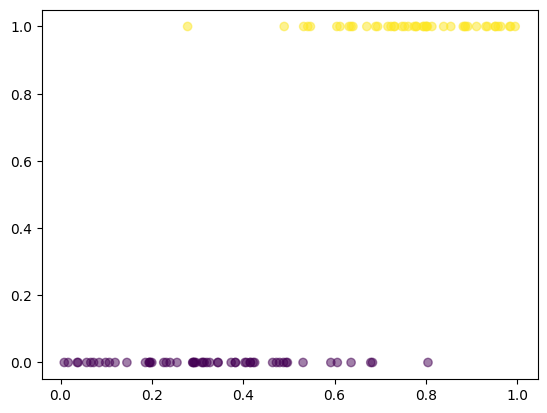

In [10]:
from scipy.special import expit

a = -5
b = 10

rng = np.random.default_rng()


def make_data(n):
    x = rng.uniform(size=n)
    p = expit(a + b * x)
    y = rng.uniform(size=n) < p
    return x, y


x, y = make_data(100)
plt.scatter(x, y, c=y, alpha=0.5)
plt.show()

In [11]:
X = x.reshape(-1, 1)
model = LogisticRegression(max_iter=10000, tol=0.000001, penalty=None)
model.fit(X, y)
ahat, bhat = model.intercept_.item(), model.coef_.item()
ahat, bhat

(-7.49358276434887, 12.984568285081238)

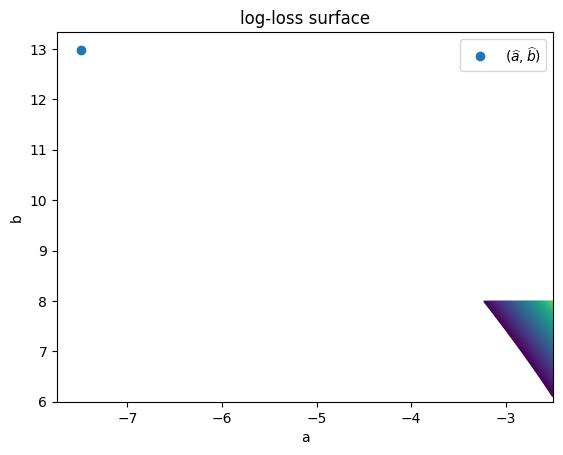

In [12]:
X = x.reshape(-1, 1, 1)
Y = y.astype(int).reshape((-1, 1, 1))

a = np.linspace(-4.25, -2.5, 100)
b = np.linspace(6, 8, 100)
A, B = np.meshgrid(a, b)
P = expit(A + B * X)

# log loss
loss = -np.mean(Y * np.log(P) + (1 - Y) * np.log(1 - P), axis=0)

plt.contour(
    A,
    B,
    loss,
    levels=np.arange(0.395, 0.6, 0.002),
)
plt.plot(ahat, bhat, "o", label="$(\\widehat{{a}}, \\widehat{{b}})$")
plt.xlabel("a")
plt.ylabel("b")
plt.legend()
plt.title("log-loss surface")
plt.show()

In [13]:
X = np.ones((100, 2))
X[:, 1] = x

fit = sm.Logit(y, X).fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.250049
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Fri, 07 Mar 2025   Pseudo R-squ.:                  0.6366
Time:                        12:24:01   Log-Likelihood:                -25.005
converged:                       True   LL-Null:                       -68.814
Covariance Type:            nonrobust   LLR p-value:                 7.940e-21
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.4935      1.526     -4.910      0.000     -10.485      -4.502
x1            12.9843      2.552      5.088      0.000       7.982      17.986
==============================================================================
"""

In [14]:
df = pd.DataFrame({"x": x, "y": y})
model = bmb.Model("y ~ x", df, family="bernoulli")
model

       Formula: y ~ x
        Family: bernoulli
          Link: p = logit
  Observations: 100
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.5)
            x ~ Normal(mu: 0.0, sigma: 3.5392)

In [15]:
fit = model.fit()
az.summary(fit)

Modeling the probability that y==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, x]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-5.662,0.971,-7.463,-3.874,0.017,0.012,3236.0,2850.0,1.0
x,9.850,1.608,6.958,12.925,0.027,0.020,3465.0,2769.0,1.0


In [16]:
df = pd.read_csv("../data/2024CFLScores.csv")
df = df[df["week"].str.startswith("Week")]
df = df[df["host_score"] != df["visitor_score"]]
df

,week,visitor,host,visitor_score,host_score
9,Week 1,MTL,WPG,27,12
10,Week 1,HAM,CGY,24,32
11,Week 1,SSK,EDM,29,21
12,Week 1,BC,TOR,27,35
13,Week 2,WPG,OTT,19,23
...,...,...,...,...,...
85,Week 20,MTL,BC,3,27
86,Week 21,HAM,OTT,31,37
87,Week 21,TOR,EDM,30,31
88,Week 21,WPG,MTL,28,27


In [17]:
teams = set(df["host"])
teams

{'BC', 'CGY', 'EDM', 'HAM', 'MTL', 'OTT', 'SSK', 'TOR', 'WPG'}

In [18]:
y = df["host_score"] > df["visitor_score"]
intercept = pd.Series(np.ones(len(df), dtype=int), index=df.index)
X = pd.DataFrame({"INTERCEPT": intercept})
for team in teams:
    X[team] = (df["host"] == team).astype(int) - (df["visitor"] == team).astype(int)
X

,INTERCEPT,EDM,TOR,MTL,HAM,OTT,CGY,BC,WPG,SSK
9,1,0,0,-1,0,0,0,0,1,0
10,1,0,0,0,-1,0,1,0,0,0
11,1,1,0,0,0,0,0,0,0,-1
12,1,0,1,0,0,0,0,-1,0,0
13,1,0,0,0,0,1,0,0,-1,0
...,...,...,...,...,...,...,...,...,...,...
85,1,0,0,-1,0,0,0,1,0,0
86,1,0,0,0,-1,1,0,0,0,0
87,1,1,-1,0,0,0,0,0,0,0
88,1,0,0,1,0,0,0,0,-1,0


In [19]:
fit0 = sm.Logit(y, X).fit()
fit0.summary()

Optimization terminated successfully.
         Current function value: 0.613740
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   79
Model:                          Logit   Df Residuals:                       70
Method:                           MLE   Df Model:                            8
Date:                Fri, 07 Mar 2025   Pseudo R-squ.:                 0.08371
Time:                        12:24:06   Log-Likelihood:                -48.485
converged:                       True   LL-Null:                       -52.915
Covariance Type:            nonrobust   LLR p-value:                    0.3543
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
INTERCEPT      0.4734      0.246      1.922      0.055      -0.009       0.956
EDM           -0.4924        nan        nan        nan         nan         nan
TOR            0.2482        nan        nan        nan         nan         nan
MTL            0.9042        nan        nan        nan         nan         nan
HAM           -0.4264        nan        nan        nan         nan         nan
OTT            0.1654        nan        nan        nan         nan         nan
CGY           -0.9125        nan        nan        nan         nan         nan
BC            -0.0182        nan        nan        nan         nan         nan
WPG            0.4531        nan        nan        nan         nan         nan
SSK            0.0787        nan        nan        nan         nan         nan
==============================================================================
"""

In [20]:
fit0_diffs = np.diff(sorted(fit0.params))
fit0_diffs

array([0.42018679, 0.06594243, 0.40818338, 0.09693025, 0.0866579 ,
       0.08281688, 0.20497082, 0.02024003, 0.43077066])

In [21]:
fit1 = sm.Logit(y, X.drop(columns=["CGY"])).fit()
fit1.summary()

Optimization terminated successfully.
         Current function value: 0.613740
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   79
Model:                          Logit   Df Residuals:                       70
Method:                           MLE   Df Model:                            8
Date:                Fri, 07 Mar 2025   Pseudo R-squ.:                 0.08371
Time:                        12:24:06   Log-Likelihood:                -48.485
converged:                       True   LL-Null:                       -52.915
Covariance Type:            nonrobust   LLR p-value:                    0.3543
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
INTERCEPT      0.4734      0.246      1.922      0.055      -0.009       0.956
EDM            0.4202      0.689      0.610      0.542      -0.929       1.770
TOR            1.1607      0.720      1.612      0.107      -0.250       2.572
MTL            1.8167      0.783      2.321      0.020       0.283       3.351
HAM            0.4861      0.713      0.682      0.495      -0.911       1.883
OTT            1.0779      0.732      1.473      0.141      -0.356       2.512
BC             0.8943      0.702      1.275      0.202      -0.481       2.270
WPG            1.3657      0.727      1.877      0.060      -0.060       2.791
SSK            0.9912      0.720      1.377      0.169      -0.420       2.403
==============================================================================
"""

In [22]:
fit1.params

INTERCEPT    0.473387
EDM          0.420187
TOR          1.160718
MTL          1.816699
HAM          0.486129
OTT          1.077901
BC           0.894313
WPG          1.365688
SSK          0.991243
dtype: float64

In [23]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty=None, tol=0.0000001)
model.fit(X.drop(columns=["INTERCEPT", "CGY"]), y)
coef_ = pd.Series(model.coef_.squeeze(), index=model.feature_names_in_, name="coef_")
print(coef_)
print(model.intercept_.item())

EDM    0.420187
TOR    1.160717
MTL    1.816699
HAM    0.486129
OTT    1.077901
BC     0.894312
WPG    1.365688
SSK    0.991243
Name: coef_, dtype: float64
0.47338692022733214


In [24]:
host_victory = df["host_score"] > df["visitor_score"]
X = pd.DataFrame({"host_victory": host_victory})
for team in teams:
    if team != "CGY":
        X[team] = (df["host"] == team).astype(int) - (df["visitor"] == team).astype(int)
X

,host_victory,EDM,TOR,MTL,HAM,OTT,BC,WPG,SSK
9,False,0,0,-1,0,0,0,1,0
10,True,0,0,0,-1,0,0,0,0
11,False,1,0,0,0,0,0,0,-1
12,True,0,1,0,0,0,-1,0,0
13,True,0,0,0,0,1,0,-1,0
...,...,...,...,...,...,...,...,...,...
85,True,0,0,-1,0,0,1,0,0
86,True,0,0,0,-1,1,0,0,0
87,True,1,-1,0,0,0,0,0,0
88,False,0,0,1,0,0,0,-1,0


In [25]:
model = bmb.Model(
    "host_victory ~ 1 + SSK + EDM + HAM + WPG + BC + MTL + TOR + OTT",
    X,
    family="bernoulli",
)
model

       Formula: host_victory ~ 1 + SSK + EDM + HAM + WPG + BC + MTL + TOR + OTT
        Family: bernoulli
          Link: p = logit
  Observations: 79
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.5)
            SSK ~ Normal(mu: 0.0, sigma: 2.1565)
            EDM ~ Normal(mu: 0.0, sigma: 2.095)
            HAM ~ Normal(mu: 0.0, sigma: 2.095)
            WPG ~ Normal(mu: 0.0, sigma: 2.095)
            BC ~ Normal(mu: 0.0, sigma: 2.095)
            MTL ~ Normal(mu: 0.0, sigma: 2.1565)
            TOR ~ Normal(mu: 0.0, sigma: 2.095)
            OTT ~ Normal(mu: 0.0, sigma: 2.1565)

In [26]:
fit = model.fit()

Modeling the probability that host_victory==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, SSK, EDM, HAM, WPG, BC, MTL, TOR, OTT]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [27]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.496,0.248,0.021,0.963,0.004,0.003,4628.0,3010.0,1.0
SSK,0.667,0.649,-0.580,1.873,0.013,0.009,2541.0,2726.0,1.0
EDM,0.097,0.617,-1.111,1.209,0.012,0.009,2533.0,2740.0,1.0
HAM,0.138,0.637,-1.068,1.303,0.014,0.010,2158.0,3194.0,1.0
WPG,1.047,0.646,-0.172,2.244,0.013,0.009,2430.0,2846.0,1.0
BC,0.581,0.619,-0.619,1.671,0.012,0.009,2603.0,3041.0,1.0
MTL,1.501,0.682,0.242,2.774,0.014,0.010,2416.0,3023.0,1.0
TOR,0.835,0.636,-0.373,2.002,0.014,0.010,2178.0,2616.0,1.0
OTT,0.752,0.649,-0.496,1.930,0.014,0.010,2299.0,2745.0,1.0


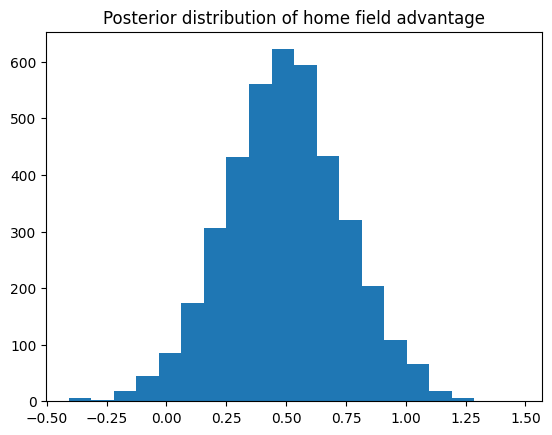

In [28]:
hfa = np.array(fit.posterior.Intercept).ravel()
plt.hist(hfa, bins=20)
plt.title("Posterior distribution of home field advantage")
plt.show()

In [29]:
np.mean(hfa > 0)

0.977

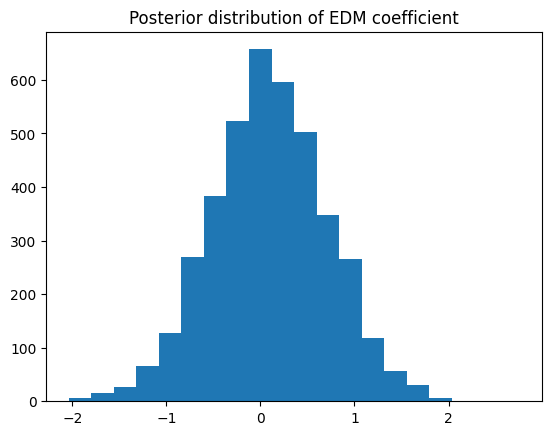

In [30]:
edm = np.array(fit.posterior.EDM).ravel()
plt.hist(edm, bins=20)
plt.title("Posterior distribution of EDM coefficient")
plt.show()

In [31]:
# What's the probability that EDM is better than CGY?
np.mean(edm > 0)

0.56725

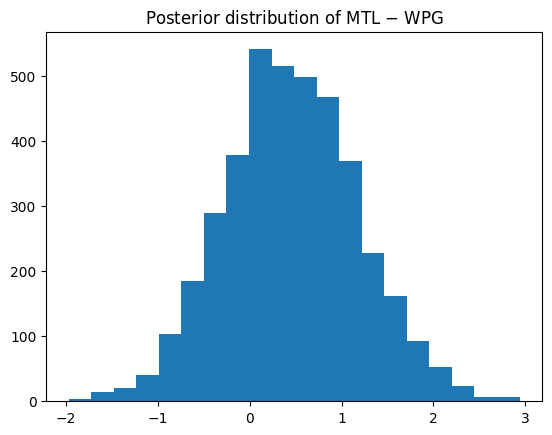

In [32]:
mtl = np.array(fit.posterior.MTL).ravel()
wpg = np.array(fit.posterior.WPG).ravel()

plt.hist(mtl - wpg, bins=20)
plt.title("Posterior distribution of MTL $-$ WPG")
plt.show()

In [33]:
np.mean(mtl > wpg)

0.73725

In [34]:
np.mean(mtl > wpg + hfa)

0.4745

In [35]:
np.mean(mtl + hfa > wpg)

0.898

In [36]:
df = pd.DataFrame(bmb.load_data("ANES"))
# df = df.loc[df["vote"] != "someone_else"]
df["clinton_voter"] = df["vote"] == "clinton"
df["is_democrat"] = df["party_id"] == "democrat"
df["is_republican"] = df["party_id"] == "republican"
df["is_independent"] = df["party_id"] == "independent"
df

,vote,age,party_id,clinton_voter,is_democrat,is_republican,is_independent
0,clinton,56,democrat,True,True,False,False
1,trump,65,republican,False,False,True,False
2,clinton,80,democrat,True,True,False,False
3,trump,38,republican,False,False,True,False
4,trump,60,republican,False,False,True,False
...,...,...,...,...,...,...,...
416,trump,46,independent,False,False,False,True
417,clinton,64,democrat,True,True,False,False
418,someone_else,31,independent,False,False,False,True
419,clinton,39,democrat,True,True,False,False


In [37]:
pd.crosstab(df["vote"], df["party_id"])

party_id,democrat,independent,republican
vote,,,
clinton,159,51,5
someone_else,10,22,16
trump,17,65,76


In [38]:
y = df["clinton_voter"]
X = df[["age", "is_democrat", "is_republican"]].copy()
X["Intercept"] = 1
X = X.astype(float)

fit = sm.Logit(y, X).fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.442452
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          clinton_voter   No. Observations:                  421
Model:                          Logit   Df Residuals:                      417
Method:                           MLE   Df Model:                            3
Date:                Fri, 07 Mar 2025   Pseudo R-squ.:                  0.3615
Time:                        12:24:13   Log-Likelihood:                -186.27
converged:                       True   LL-Null:                       -291.72
Covariance Type:            nonrobust   LLR p-value:                 1.868e-45
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
age              -0.0126      0.008     -1.648      0.099      -0.028       0.002
is_democrat       2.3191      0.275      8.443      0.000       1.781       2.857
is_republican    -2.3540      0.493     -4.777      0.000      -3.320      -1.388
Intercept         0.0725      0.405      0.179      0.858      -0.722       0.867
=================================================================================
"""

In [39]:
df["age*is_democrat"] = df["age"] * df["is_democrat"]
df["age*is_republican"] = df["age"] * df["is_republican"]
df["age*is_independent"] = df["age"] * df["is_independent"]
df

,vote,age,party_id,clinton_voter,is_democrat,is_republican,is_independent,age*is_democrat,age*is_republican,age*is_independent
0,clinton,56,democrat,True,True,False,False,56,0,0
1,trump,65,republican,False,False,True,False,0,65,0
2,clinton,80,democrat,True,True,False,False,80,0,0
3,trump,38,republican,False,False,True,False,0,38,0
4,trump,60,republican,False,False,True,False,0,60,0
...,...,...,...,...,...,...,...,...,...,...
416,trump,46,independent,False,False,False,True,0,0,46
417,clinton,64,democrat,True,True,False,False,64,0,0
418,someone_else,31,independent,False,False,False,True,0,0,31
419,clinton,39,democrat,True,True,False,False,39,0,0


In [40]:
y = df["clinton_voter"]
X = df[
    ["age", "is_democrat", "is_republican", "age*is_democrat", "age*is_republican"]
].copy()
X["Intercept"] = 1
X = X.astype(float)

fit = sm.Logit(y, X).fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.432519
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          clinton_voter   No. Observations:                  421
Model:                          Logit   Df Residuals:                      415
Method:                           MLE   Df Model:                            5
Date:                Fri, 07 Mar 2025   Pseudo R-squ.:                  0.3758
Time:                        12:24:13   Log-Likelihood:                -182.09
converged:                       True   LL-Null:                       -291.72
Covariance Type:            nonrobust   LLR p-value:                 2.144e-45
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                  -0.0225      0.011     -2.113      0.035      -0.043      -0.002
is_democrat           0.7496      0.800      0.936      0.349      -0.819       2.319
is_republican         0.0510      1.625      0.031      0.975      -3.133       3.235
age*is_democrat       0.0328      0.016      2.018      0.044       0.001       0.065
age*is_republican    -0.0590      0.042     -1.417      0.157      -0.141       0.023
Intercept             0.5405      0.531      1.018      0.309      -0.501       1.582
=====================================================================================
"""

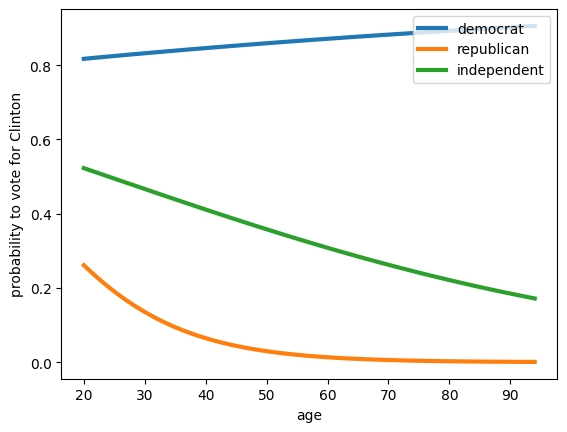

In [41]:
X_dem = pd.DataFrame({"age": np.arange(20, 95)})
X_dem["is_democrat"] = 1
X_dem["is_republican"] = 0
X_dem["age*is_democrat"] = X_dem["age"] * X_dem["is_democrat"]
X_dem["age*is_republican"] = X_dem["age"] * X_dem["is_republican"]
X_dem["Intercept"] = 1
plt.plot(X_dem["age"], fit.predict(X_dem), label="democrat", lw=3)

X_rep = pd.DataFrame({"age": np.arange(20, 95)})
X_rep["is_democrat"] = 0
X_rep["is_republican"] = 1
X_rep["age*is_democrat"] = X_rep["age"] * X_rep["is_democrat"]
X_rep["age*is_republican"] = X_rep["age"] * X_rep["is_republican"]
X_rep["Intercept"] = 1
plt.plot(X_rep["age"], fit.predict(X_rep), label="republican", lw=3)

X_ind = pd.DataFrame({"age": np.arange(20, 95)})
X_ind["is_democrat"] = 0
X_ind["is_republican"] = 0
X_ind["age*is_democrat"] = X_ind["age"] * X_ind["is_democrat"]
X_ind["age*is_republican"] = X_ind["age"] * X_ind["is_republican"]
X_ind["Intercept"] = 1
plt.plot(X_ind["age"], fit.predict(X_ind), label="independent", lw=3)

plt.legend(loc="upper right")
plt.xlabel("age")
plt.ylabel("probability to vote for Clinton")
plt.show()

In [42]:
model = bmb.Model("clinton_voter ~ party_id + party_id:age", df, family="bernoulli")
fit = model.fit()

Modeling the probability that clinton_voter==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, party_id, party_id:age]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [43]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.012,0.493,0.078,1.912,0.008,0.006,3470.0,2809.0,1.0
party_id[independent],-0.383,0.626,-1.562,0.780,0.011,0.009,3221.0,2594.0,1.0
party_id[republican],-0.505,0.832,-2.057,1.120,0.015,0.012,3159.0,2484.0,1.0
party_id:age[democrat],0.016,0.011,-0.002,0.037,0.000,0.000,3369.0,2836.0,1.0
party_id:age[independent],-0.024,0.010,-0.043,-0.006,0.000,0.000,3360.0,2483.0,1.0
party_id:age[republican],-0.079,0.023,-0.126,-0.038,0.000,0.000,2451.0,2135.0,1.0


In [44]:
age = np.arange(18, 91)
new_data = pd.DataFrame(
    {
        "age": np.tile(age, 3),
        "party_id": np.repeat(["democrat", "republican", "independent"], len(age)),
    }
)
new_data

,age,party_id
0,18,democrat
1,19,democrat
2,20,democrat
3,21,democrat
4,22,democrat
...,...,...
214,86,independent
215,87,independent
216,88,independent
217,89,independent


In [45]:
model.predict(fit, data=new_data)

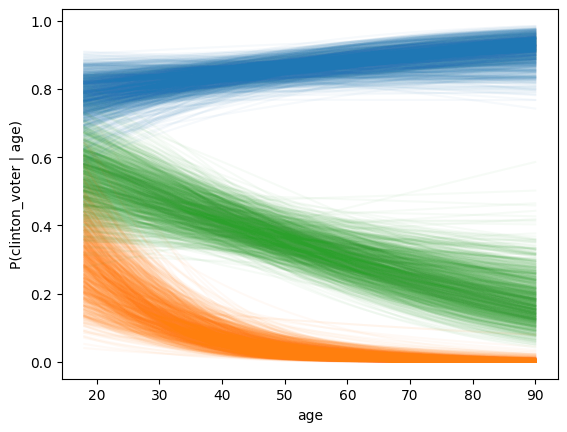

In [51]:
p = fit.posterior["p"][0]

for j in range(1000):
    plt.plot(age, p[j, :73], "C0", alpha=0.04)
    plt.plot(age, p[j, 73 : 2 * 73], "C1", alpha=0.04)
    plt.plot(age, p[j, 2 * 73 : 3 * 73], "C2", alpha=0.04)

plt.xlabel("age")
plt.ylabel("P(clinton_voter | age)")
plt.show()

In [52]:
from formulae import design_matrices

In [ ]:
df = pd.DataFrame(bmb.load_data("ANES"))

mats = design_matrices("vote[clinton] ~ party_id + age:party_id", df)

X = mats.common.as_dataframe()
y = np.array(mats.response)

In [71]:
fit = sm.Logit(y, X).fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.432519
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  421
Model:                          Logit   Df Residuals:                      415
Method:                           MLE   Df Model:                            5
Date:                Fri, 07 Mar 2025   Pseudo R-squ.:                  0.3758
Time:                        12:34:46   Log-Likelihood:                -182.09
converged:                       True   LL-Null:                       -291.72
Covariance Type:            nonrobust   LLR p-value:                 2.144e-45
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.2901      0.599      2.154      0.031       0.116       2.464
party_id[independent]        -0.7496      0.800     -0.936      0.349      -2.319       0.819
party_id[republican]         -0.6985      1.648     -0.424      0.672      -3.928       2.531
age:party_id[democrat]        0.0103      0.012      0.841      0.400      -0.014       0.034
age:party_id[independent]    -0.0225      0.011     -2.113      0.035      -0.043      -0.002
age:party_id[republican]     -0.0815      0.040     -2.023      0.043      -0.161      -0.003
=============================================================================================
"""

In [75]:
X_new = design_matrices("party_id + party_id:age", new_data).common.as_dataframe()
X_new

,Intercept,party_id[independent],party_id[republican],party_id[democrat]:age,party_id[independent]:age,party_id[republican]:age
0,1.0,0.0,0.0,18.0,0.0,0.0
1,1.0,0.0,0.0,19.0,0.0,0.0
2,1.0,0.0,0.0,20.0,0.0,0.0
3,1.0,0.0,0.0,21.0,0.0,0.0
4,1.0,0.0,0.0,22.0,0.0,0.0
...,...,...,...,...,...,...
214,1.0,1.0,0.0,0.0,86.0,0.0
215,1.0,1.0,0.0,0.0,87.0,0.0
216,1.0,1.0,0.0,0.0,88.0,0.0
217,1.0,1.0,0.0,0.0,89.0,0.0


In [ ]:
y_new = fit.predict(X_new)  # probabilities
y_new

0      0.813991
1      0.815551
2      0.817102
3      0.818642
4      0.820171
         ...   
214    0.198856
215    0.195298
216    0.191788
217    0.188326
218    0.184913
Length: 219, dtype: float64

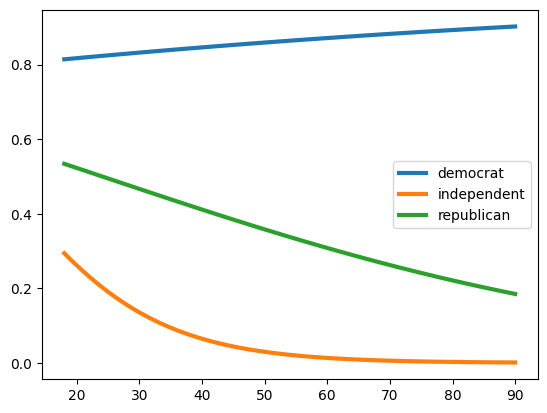

In [ ]:
for i, party_id in enumerate(["democrat", "independent", "republican"]):
    plt.plot(age, y_new[i * len(age) : (i + 1) * len(age)], lw=3, label=party_id)
plt.legend()